<a href="https://colab.research.google.com/github/nianlonggu/Tensorflow-Notebooks/blob/master/Tensorflow_TPU_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple tutorial of using Tensorflow TPU in Google Colab
In this document, I provide a full example of how to use tensorfloe TPU in Colab. The common example of iris species recognition provided in [official turtorials](https://cloud.google.com/tpu/docs/tutorials/migrating-to-tpuestimator-api) contains many extra information, like dealing with the feature columns and manage the name of each dimension of the feature vector. This makes it sometimes misleading for the readers  to capture the key aspect of how to use TPU in their customized code. In this example, I modified the official document, and try to achieve the task of hand-written digit recognition in MNIST dataset.

The main topics include: 
1. **tensorflow Dataset API**
2. **tensorflow TPUEstimator API**
3. **Google Cloud Storage**

## Task Description
Given an hand-written image, like: 

![MNIST](https://github.com/nianlonggu/Tensorflow-Notebooks/blob/master/figures/5.png?raw=true)

the task is to train a CNN to correctly detect the number of the hand-written digit (5 in this case).  A typical way for training is to train the model using large number of ( **X**, **y** ) pairs, where **X** is the pixel matrix of an image and **y** is the corresponding label. This is a fully supervised training scheme.

To use TPU tp achive this task, there are multiple ways. One is first design the model using keras, and then use the ** tf.contrib.tpu.keras_to_tpu_model** to cast the code to TPU specific code. Clike[ here ](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb)to see the introduction.

Another way is to design a customized TPUEstimator, and then run the train, evaluate and predict function. This method has a unified framework for general supervised training problems and is easier to tranfer over different computation platforms (CPU, GPU, TPU). This is also the main topic of this document.

**Note**: before runing, clike in colab the "Edit"->"Notebook Setting" and choose TPU as accelerator!

## Start of Coding

### import python libraries

In [1]:
import tensorflow as tf
import numpy as np
import keras.datasets.mnist as mnist
import math
import os
## plt is used to plot the results
import matplotlib.pyplot as plt

Using TensorFlow backend.


Different from keras_to_tpu_model, if we want use TPUEstimator in colab, the checkpoints files cannot be stored locally in colab. You will get an error like:

***file system scheme '[local]' not implemented***

As far as I know, the only choice is to store the ckpt files in **Google Cloud Storage**.  To solve this without any additional cost, you can visit https://cloud.google.com/storage/ , apply for a 1-year free trail accout, and activate the billing service. After this, following the website instruction to create a new Google cloud storage bucket with a name like "awesome_gcs_bucket". Then you get a address to acess the GCS: ** gs://awesome_gcs_bucket**  

After get the GCS address, you need to authorize you google colab to get access to you Google Cloud Storage Busket using the following commands:

In [0]:
from google.colab import auth
auth.authenticate_user()

### Create a Flag Class to hold all the global hyperparameters. 
This can also be achived by using tf.flags. Note that there are some bugs realated with tf.flags in Colab, simply add "flags.DEFINE_string('f', '', 'kernel')" to avoid it

In [0]:
class Flags:
    def __init__(self):
        ## tpu store the address of TPU, used to passed to the TPUClusterResolver
        self.tpu = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        ## model_dir specify the path to store the model parameters. Here we need to use the adress to the cloud storage bucket
        ## model_dir will be passed to the tpu.RunConfig() function
        self.model_dir = "gs://awesome_gcs_bucket"
        """ batch_size: the batch size used for training, evaluation and prediction. It should be a multiple of the number of TPU cores.
        Normally the number of TPU cores is 8, so the batch_size is usually 128. The reason for this is during TPU running, each batch of 
        data will be dispatched to each TPU cores, so the batch size should be divisable by the number of TPU cores."""
        self.batch_size = 128
        """ train_steps define the number of steps of the total training procedure. In each step a batch of data a fed into the TPU for 
        computation. Note that in TPUEstimator train function there are two parameters: steps and max_steps. 
        "steps" means the further number of steps to be trained from now;
        "max_steps" means the total maximum number of steps.
        """
        self.train_steps = 10000
        """iterations_per_loop defines the number of train batches (steps) in TPU within one Session.run(), before returning to the CPU host
        to prepare next group of train batches
        """
        self.iterations_per_loop = 500
        ## the bool flag for using tpu or not
        self.use_tpu = True

    
#Create an entity of Class Flag, FLAGS is the global hyperparameter
FLAGS = Flags()


### Preprocessing Operation: load raw data and image plotting

In [0]:
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_eval = x_train[-5000:]/255.0
    x_eval = np.expand_dims(x_eval, -1).astype(np.float32)  ## must convert float64 into np.float32 since the former is not supported by TPU!
    y_eval = y_train[-5000:].astype(np.int32) ## convert to np.int32 which is recognized by TPU
    x_train = x_train[ :-5000]/255.0
    x_train = np.expand_dims(x_train, -1).astype(np.float32)
    y_train = y_train[ :-5000].astype(np.int32)  ## by default y_train is not one-hot coded
    x_test = x_test/255.0
    x_test = np.expand_dims(x_test, -1).astype(np.float32)
    y_test = y_test.astype(np.int32)
  
    return x_train, y_train, x_eval, y_eval, x_test, y_test


## load the train/ eval and predict data
x_train, y_train, x_eval, y_eval, x_test, y_test = load_mnist_data()

Define the helper function for plotting images.

In [0]:
def plot_images( images, labels=None, preds= None  ):
    images = np.squeeze(images )
    num = images.shape[0]
    n_rows = math.floor( math.sqrt( num ))
    n_columns = math.ceil(math.sqrt(num))
  
    fig, axes = plt.subplots( n_rows, n_columns )
  
    if n_rows * n_columns == 1:
        axes = [axes]
    else:
        axes = axes.flat
  
    for i, ax in enumerate( axes ):
        if i < num:
            ax.imshow( images[i] )
            xlabel= ""
        if labels is not None:
            xlabel += "True: %d "%(labels[i])
        if preds is not None:
            xlabel += "Pred: %d"%(preds[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Define the functions required by the TPUEstimator: input_functions and model_dunction
The key part of using TPU is the TPUEstimator, this class contains the following main aspects:

I. Parameters:
1. model_fn:  
The model_fn refers to a self-defined model function, this functions contains the contruction of network structure, as well as different operation for different value of the mode parameter.
2. config:
tpu.RunConfig() which contains the configuration of running: 
3. use_tpu:
use TPU or not
4. train/eval/predict_batch_size
5. params:
The model_fn is requred to have a parameter params which is a dict, apart from other defined key-value pair, params contains pre-defined "batch_size" key-value, this will be used to be allocated to the batch_size paramters of train/eval/predict_input_fn.

II. Methods:
1. train( input_fn ,  steps  )  # steps used to determine the number of batches from the start of training
2. eval( input_fn, steps  )  # steps defines the number of batches from the start of evaluation, used to compute the overall evaluation metrics like accuracy, loss, etc.
3. predict( input_fn )

#### The input function part:

In [0]:
def train_input_fn( features, labels, batch_size ):
    """An input function for training
    features: corresponding to x_train
    labels: corresponding to y_train
    batch_size: will be assigned by the reserved key-value pair params["batch_size"]
    """
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # Shuffle, repeat.
    dataset = dataset.shuffle(1000).repeat() # repeat without parameters means get random batches from training dataset within unlimited times
    # TPU specific batch the slices, to make sure that the batch size of each acquired batch is divisible by the number of TPU cores
    dataset = dataset.batch( batch_size, drop_remainder = True )
    # Return the dataset.
    return dataset

In [0]:
def eval_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # 1000 is the buffer size for shuffling
    dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.batch(batch_size, drop_remainder = True )
    # Return the dataset.
    return dataset

In [0]:
def predict_input_fn(features, labels,batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    # For predict use_tpu should be False, since drop_remainder is False
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # for prediction, shuffle() and repeat() is not needed, since all data will be predicted
    # for prediction, since no need to guarantee the high performance of TPU, so no need to set drop_remainder= True
    dataset = dataset.batch(batch_size)
    # Return the dataset.
    return dataset

In [0]:
def metric_fn(labels, logits):
    """Function to return metrics for evaluation.
    The input parameters can be arbritary
    """
    predicted_classes = tf.argmax(logits, 1)
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    
    return {"accuracy": accuracy}

#### The model_fn part

In [0]:

def model_fn(features, labels, mode, params):
    # Args:
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn,
    #           see e.g. train_input_fn for these two.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    

    """ Part I. create the model networks"""
    x = features
    # First convolutional layer.
    net = tf.layers.conv2d(inputs=x, name='layer_conv1',filters=32, kernel_size=5,
                           padding='same', strides = 2 ,activation=tf.nn.relu)
    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2', filters=64, kernel_size=5,
                           padding='same', strides =2 ,activation=tf.nn.relu)   
   
    net = tf.contrib.layers.flatten(net)
    net = tf.layers.dense(inputs=net, name='layer_fc1', units=128, activation=tf.nn.relu)    
    logits = tf.layers.dense(inputs=net, name='layer_fc2',units=10)
    
    
    
    """Part II. define the loss and relative parameters for mode == TRAIN/EVAL/PREDICT"""
    ## compute loss
    loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    # Softmax output of the neural network.
    y_pred_probabilities = tf.nn.softmax(logits=logits)
    # Classification output of the neural network.
    y_pred_classes = tf.argmax(y_pred_probabilities, axis=1)


    
    ## operations for the training mode, define the optimizer, and reconfig it using tpu.CrossShardOptimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        # Define the optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])
        if FLAGS.use_tpu:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())

        spec= tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=loss,train_op= train_op  )
    ## for EVAL mode, the parameters eval_metrics takes a tuple or list of two elements. The first element is a callable function,
    ## The second element is a list of parameters. The return value of the callable function will be shown in the evaluatio results
    elif mode == tf.estimator.ModeKeys.EVAL:
        spec = tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, logits] ) )

    ## operations for PREDICT:  given the input images, return a dict which contains the reqired information (predicted y label)
    elif mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
              "true_class":  labels ,
              "pred_class":  y_pred_classes,
              "probability": y_pred_probabilities,
        }
        spec = tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

        
    return spec

### Create the TPUEstimator entity, and run the train / evaluate/ predict

In [11]:
run_config = tf.contrib.tpu.RunConfig(
    model_dir=FLAGS.model_dir,
    cluster=tf.contrib.cluster_resolver.TPUClusterResolver(FLAGS.tpu),
    session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(FLAGS.iterations_per_loop),
    )

model = tf.contrib.tpu.TPUEstimator(
                               model_fn=model_fn,
                               params = {"learning_rate": 1e-4 },
                               config = run_config,
                               use_tpu= FLAGS.use_tpu,
                               train_batch_size=FLAGS.batch_size,
                               eval_batch_size=FLAGS.batch_size,
                               predict_batch_size=FLAGS.batch_size,
                              )


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': 'gs://awesome_gcs_bucket', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
log_device_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.26.247.138:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcec988dcf8>, '_task_type': 'worker', '_task_id': 0, '_global_id

### Training

In [12]:
""" lambda is an anonymous function which has a parameter params, this params is further passed to the batch_size parameter of train_input_fn
The reason for this setting is in TPUEstimator the input_fn is required to have only one parameter "params", so the model_fn params can be passed
to the input_fn to control the batch_size on live. Using lambda function encapsulate the train_input_fn into a function with only one parameter params
"""
## steps= 10000 means 10000 batchs is fed into the TPU. With a batch_size = 128, it accounts for 1280000 samples. For MNIST data the number
## of train samples are around 60000, 10000 steps means 1280000/60000 = 21 epochs
model.train( input_fn = lambda params: train_input_fn( x_train, y_train, params["batch_size"] ), steps=2000  )

INFO:tensorflow:Querying Tensorflow master (grpc://10.26.247.138:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3268548067848416981)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16597060784137536254)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8135305259230580745)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16537533837436394017)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16383102542737394051)
INFO:tensorflow:*** Available Device: _DeviceAttribute

### Evaluate

In [13]:
eval_result = model.evaluate(input_fn=lambda params: eval_input_fn( x_eval, y_eval, params["batch_size"]), steps = 10)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-09T10:46:52Z
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from gs://awesome_gcs_bucket/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 10 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Enqueue next (10) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (10) batch(es) of data from outfeed.
INFO:tensorflow:Evaluation [10/10]
INFO:tensorf

In [14]:
eval_result

{'accuracy': 0.9664062, 'global_step': 2000, 'loss': 0.056997508}

### Predict

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://awesome_gcs_bucket/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 13 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.
Prediction is 7, probility 1.0, expected 7
Prediction is 2, probility 1.0, expected 2
Prediction is 1, probility 1.0, expected 1
Prediction is 0, probility 1.0, expected 0
Prediction is 4, probility 1.0, expected 4
Prediction is 1, probility 1.0, expected 1
Prediction is 4, probility 1.0, expected 4
Prediction is 9, prob

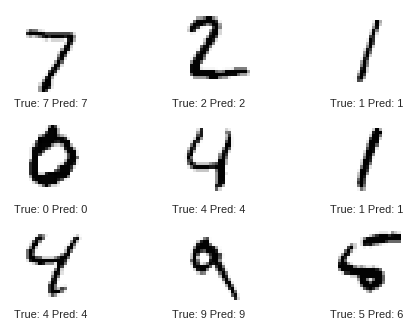

In [15]:
predict_result = model.predict(input_fn=lambda params: predict_input_fn(x_test[0:9],y_test[0:9], params["batch_size"]))

images = []
true_classes =[]
pred_classes =[]

for pred_dict, image, true_class in zip( predict_result, x_test, y_test  ):
    pred_class = pred_dict["pred_class"]
    pred_prob = pred_dict["probability"][pred_class]
    print( "Prediction is %d, probility %.1f, expected %d" %( pred_class, pred_prob, true_class )  )
    images.append(image)
    true_classes.append( true_class )
    pred_classes.append( pred_class )

plot_images( np.asarray(images), np.asarray(true_classes), np.asarray( pred_classes )  )

This is a complete procedure of using TPU in Colab. In the further, runing more complicated model like GAN on TPU will be tried. Hope this may help.